In [ ]:
def connect():
    #connect
    ftp = FTP('83.149.249.48')
    ftp.login()
    
    #go to directory
    ftp.cwd('dataset')
    

def count_files():
    #go to fragments directory
    ftp.cwd('dataset_fragments')

    #count
    total_lines = 0
    all_folders = ftp.nlst()
    for folder in all_folders:
        ftp.cwd(folder)
        lines = ftp.nlst()
        print('folder:', folder, len(lines))
        total_lines += len(lines)
        ftp.cwd('../')
    print('total files:', total_lines)
    
def download_fragments_data():
    filename = 'fragments.csv'
    with open(filename, "wb") as file_handle:
        ftp.retrbinary("RETR " + filename, file_handle.write)
    
def download_first_image():
    all_files= ftp.nlst()
    filename = all_files[0]
    images = []
    with open(filename, "wb") as file_handle:
        ftp.retrbinary("RETR " + filename, file_handle.write)

def show_image(image_name='1.jpg'):
    image = imread(image_name)
    imgplot = plt.imshow(image)
    
def show_images():
    columns = 3
    rows = 5
    path = os.getcwd() + '\\Data'
    images = os.listdir(path)
    fig=plt.figure(figsize=(30, 50))
    i = 1
    for image_name in images:
        #print(int(image_name))
        image = imread(path + '\\' + image_name)
        fig.add_subplot(rows, columns, i)
        plt.imshow(image)
        i += 1
    plt.show()
    
def clean_data():
    shutil.rmtree('Data', ignore_errors=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 252, 252, 16)      416       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 30, 32)       

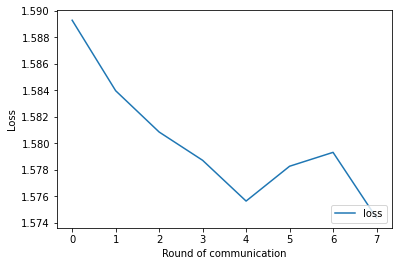

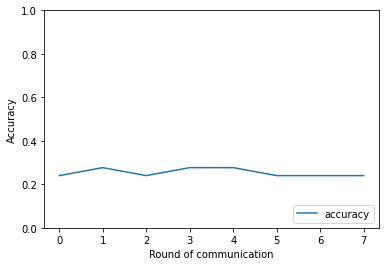

In [8]:
#check if minibutching works correct
import worker
import server
import utils
from sklearn.utils import shuffle

worker = worker.Worker(shard_size=8000, seed = 0)
worker.get_data(folder = 'Data8000_0')
worker.preprocess_data()
worker.model = utils.make_model(learning_rate=0.01, regularization_rate=0.0001)

minibatch_size = 100
local_steps = 80
serv = server.Server(num_workers=0,
                     shard_size=8000,
                     #learning_rate=learning_rate,
                     #regularization_rate=regularization_rate,
                     debug=True)

for r in range(8):
    X_train, y_train = shuffle(worker.X_train, worker.y_train, random_state=worker.seed+r)
    for i in range(local_steps):
            #get minibutch
            X_batch = X_train[i*minibatch_size:i*minibatch_size + minibatch_size]
            y_batch = y_train[i*minibatch_size:i*minibatch_size + minibatch_size]
            #print(y_batch) #it's ok
            
            worker.model.train_on_batch(X_batch, y_batch)
    print()
    serv.model = worker.model
    serv.test_model()
serv.plot_history()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_28 (Rescaling)     (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 252, 252, 16)      416       
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 30, 30, 32)      

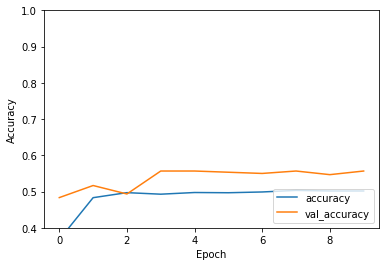

In [74]:
#simple model fit on 8000 images

import worker
import utils
import server
import matplotlib.pyplot as plt
import tensorflow as tf

w = worker.Worker(shard_size=8000, seed = 0)
w.get_data(folder = 'Data8000_0')
w.preprocess_data()
w.model = utils.make_model(learning_rate=0.001, regularization_rate=0.0001)
model_copy = tf.keras.models.clone_model(w.model)

serv = server.Server(num_workers=0,
                     shard_size=8000,
                     #learning_rate=learning_rate,
                     #regularization_rate=regularization_rate,
                     debug=True)
serv.get_test_data()
serv.preprocess_test_data()
X_test = serv.X_test
y_test = serv.y_test

print(w.model.optimizer.learning_rate)
history = w.model.fit(w.X_train, w.y_train, epochs=10, 
                    validation_data=(X_test, y_test))
print(w.model.optimizer.learning_rate)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

test_loss, test_acc = w.model.evaluate(X_test,  y_test, verbose=2)

In [66]:
#simple model fit on 24000 images

import pandas as pd
import worker
import server
import matplotlib.pyplot as plt

w = worker.Worker(shard_size=8000, seed = 0)
w.get_data(folder = 'Data8000_0')
data = w.df

w = worker.Worker(shard_size=8000, seed = 1)
w.get_data(folder = 'Data8000_1')
data = pd.concat([data, w.df], axis=0)

w = worker.Worker(shard_size=8000, seed = 2)
w.get_data(folder = 'Data8000_2')
data = pd.concat([data, w.df], axis=0)

w.df = data
w.preprocess_data()
w.model = utils.make_model(learning_rate=None, regularization_rate=0.0001)
model_copy = w.model

serv = server.Server(num_workers=0,
                     shard_size=8000,
                     #learning_rate=learning_rate,
                     #regularization_rate=regularization_rate,
                     debug=True)
serv.get_test_data()
serv.preprocess_test_data()
X_test = serv.X_test
y_test = serv.y_test

print(w.model.optimizer.learning_rate)
history = w.model.fit(w.X_train, w.y_train, epochs=10, 
                    validation_data=(X_test, y_test))
print(w.model.optimizer.learning_rate)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

test_loss, test_acc = w.model.evaluate(X_test,  y_test, verbose=2)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_21 (Rescaling)     (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 252, 252, 16)      416       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 30, 30, 32)      

NameError: name 'self' is not defined

In [65]:
import math

num_workers = 3
data_size = 24000
shard_size = 8000
minibatch_size = 128
epochs = 8
T = (shard_size / minibatch_size) * epochs
local_updates = int((T**(2/3))/((num_workers*minibatch_size)**(1/3)))
rounds = math.ceil(T / local_updates)


L = 1000
Mu = 0.001


k = L/Mu #condition number

first = 1/math.log(data_size/(k**2) * (k/local_updates + data_size))
print('first: ', first)
second = k/local_updates + data_size
print('second:', second)
alpha = max(first, second)
a = alpha * local_updates + 4

for r in range(10):
    print("learning rate:%.7f" % (4 / (Mu * (r * local_updates + a))))

first:  -0.1775092127553756
second: 149000.0
learning rate:0.0033557
learning rate:0.0033557
learning rate:0.0033556
learning rate:0.0033556
learning rate:0.0033556
learning rate:0.0033556
learning rate:0.0033556
learning rate:0.0033555
learning rate:0.0033555
learning rate:0.0033555
